In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import h5py
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from torch.utils.data import IterableDataset, DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
import torchaudio

sns.set_theme(context="poster", style="darkgrid", palette="colorblind")

torch.manual_seed(1)
np.random.seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.deterministic = True
print("Device:", device)

Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the zip file
!unzip /content/drive/MyDrive/Data_Ass3.zip -d "."

Archive:  /content/drive/MyDrive/Data_Ass3.zip
   creating: ./Data_Ass3/
   creating: ./Data_Ass3/Cross/
   creating: ./Data_Ass3/Cross/test1/
  inflating: ./Data_Ass3/Cross/test1/rest_162935_1.h5  
  inflating: ./Data_Ass3/Cross/test1/rest_162935_10.h5  
  inflating: ./Data_Ass3/Cross/test1/rest_162935_3.h5  
  inflating: ./Data_Ass3/Cross/test1/rest_162935_5.h5  
  inflating: ./Data_Ass3/Cross/test1/task_motor_162935_1.h5  
  inflating: ./Data_Ass3/Cross/test1/task_motor_162935_3.h5  
  inflating: ./Data_Ass3/Cross/test1/task_motor_162935_4.h5  
  inflating: ./Data_Ass3/Cross/test1/task_motor_162935_9.h5  
  inflating: ./Data_Ass3/Cross/test1/task_story_math_162935_2.h5  
  inflating: ./Data_Ass3/Cross/test1/task_story_math_162935_3.h5  
  inflating: ./Data_Ass3/Cross/test1/task_story_math_162935_4.h5  
  inflating: ./Data_Ass3/Cross/test1/task_story_math_162935_6.h5  
  inflating: ./Data_Ass3/Cross/test1/task_working_memory_162935_3.h5  
  inflating: ./Data_Ass3/Cross/test1/task_wor

In [ ]:
def get_label(file_name):
    keys = ["rest", "math", "memory", "motor"]
    classes = len(keys)
    label = None
    for cls, key in enumerate(keys):
        if key in file_name:
            label = F.one_hot(torch.tensor(cls), classes)
            break
    if label is None:
        return torch.zeros((classes,))
    else:
        return label

def to_index(label):
    return label.argmax(axis=-1)

class MEGDataset(IterableDataset):
    def __init__(self, root, stride=1, window=1, transform=lambda x: x):
        """
        Args:
            root: folder with the files
            transform: apply this function to each file
            stride: when reading the data, advance of this number of time steps
            window: return this number of timesteps
        """
        # Store file locations
        self.files = glob.glob(root + "/*.h5")
        self.current = None
        self.chunk_shape = None
        self.transform = transform
        self.current_label = None
        self.stride = stride
        self.window = window

    def __iter__(self):
        # Open a new file if at the end of the current file
        while len(self.files) != 0 or self.current is not None:
            if self.current == None:
                next_file = self.files.pop()  # Note: remove and return the last element
                f = h5py.File(next_file,'r')
                key = list(f.keys())[0] # Assume one dataset each file
                tmp = torch.tensor(np.array(f[key]))
                tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())
                self.current = self.transform(tmp)
                self.chunk_shape = self.current.shape
                self.current_label = get_label(next_file)

            for i in range(0, self.chunk_shape[1], self.stride):   
                window = self.current[:, i:i+self.window].float() #.astype(np.float32)
                window = np.concatenate((window, np.zeros((window.shape[0], self.window - window.shape[1]))), axis=-1).astype(np.float32)             
                yield window, self.current_label.float()
            self.current = None

# If it fits in memory, we can use this
class MEGDataset2(Dataset):
    def __init__(self, root, stride=1, window=1, transform=lambda x: x):
        # Store file locations
        self.files = glob.glob(root + "/*.h5")
        self.data = [None for i in self.files]
        self.labels = [None for i in self.files]
        self.len = 0
        self.transform = transform
        self.stride = stride
        self.window = window
        for i, file in enumerate(self.files):
            f = h5py.File(file, 'r')
            key = list(f.keys())[0] # Assume one dataset each file
            tmp = torch.tensor(np.array(f[key]))
            tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())
            self.data[i] = self.transform(tmp)
            self.labels[i] = get_label(file)
            self.len += self.data[i].shape[1] // self.stride # Adjust length
        self.chunk = self.data[-1].shape[1]        

    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        index = index * self.stride  # actual position
        pos_index = index % self.chunk
        data_index = index // self.chunk
        window = self.data[data_index][:, pos_index:pos_index+self.window].float() #.astype(np.float32)
        window = np.concatenate((window, np.zeros((window.shape[0], self.window - window.shape[1]))), axis=-1).astype(np.float32)
        return window , self.labels[data_index].float()

## Load the data and make the datasets

In [ ]:
chunk_shape = (248, 35624) # Divisors of 35624: 2 2 2 61 73
batch_size = 128
original_rate = 2034
new_rate = 500
labels = 4
target_names = ["rest", "math", "memory", "motor"]
root = "./"  # Location of the dataset
window = new_rate
stride = 5 
resampler = lambda x: torchaudio.functional.resample(x, original_rate, new_rate)

def make_train_sets():
    
    intra_train = MEGDataset2(root + "Data_Ass3/Intra/train", stride, window, resampler)
    cross_train = MEGDataset2(root + "Data_Ass3/Cross/train", stride, window, resampler)

    # pin_memory=True should make that transfer cpu->gpu faster
    # if it causes problems: remove it
    intra_data_train  = DataLoader(intra_train, shuffle=True, batch_size = batch_size, pin_memory=True)    
    cross_data_train  = DataLoader(intra_train, shuffle=True, batch_size = batch_size, pin_memory=True)

    return intra_train, cross_train, intra_data_train, cross_data_train


def make_test_sets():
    intra_test = MEGDataset2(root + "Data_Ass3/Intra/test", stride, window, resampler)
    cross_test1 = MEGDataset2(root + "Data_Ass3/Cross/test1", stride, window, resampler)
    cross_test2 = MEGDataset2(root + "Data_Ass3/Cross/test2", stride, window, resampler)
    cross_test3 = MEGDataset2(root + "Data_Ass3/Cross/test3", stride, window, resampler)

    intra_data_test  = DataLoader(intra_test, batch_size = batch_size, pin_memory=True)
    cross_data_test1  = DataLoader(cross_test1, batch_size = batch_size, pin_memory=True)
    cross_data_test2  = DataLoader(cross_test2, batch_size = batch_size, pin_memory=True)
    cross_data_test3  = DataLoader(cross_test3, batch_size = batch_size, pin_memory=True)

    return intra_test, cross_test1, cross_test2, cross_test3, intra_data_test, cross_data_test1, cross_data_test2, cross_data_test3

intra_train, cross_train, intra_data_train, cross_data_train = make_train_sets()
intra_test, cross_test1, cross_test2, cross_test3, intra_data_test, cross_data_test1, cross_data_test2, cross_data_test3 = make_test_sets()



In [ ]:
print("Cross - train samples:", len(cross_train))
print("Intra - train samples:", len(intra_train))

Cross - train samples: 112064
Intra - train samples: 56032


## Define the model

In [ ]:
# Example of how to use the convolutional layer
# Input: 20 samples with 16 channels and length 30 
# Output: 20 samples with 33 channels and length 28
"""
m = nn.Conv1d(16, 33, 3, stride=1) # channels in - channels out - kernel size
input = torch.randn(20, 16, 30)  # batch - channels in - elements
output = m(input)
output.shape # batch - channels out - new length (from formula)
--> torch.Size([20, 33, 28])
"""

'\nm = nn.Conv1d(16, 33, 3, stride=1) # channels in - channels out - kernel size\ninput = torch.randn(20, 16, 30)  # batch - channels in - elements\noutput = m(input)\noutput.shape # batch - channels out - new length (from formula)\n--> torch.Size([20, 33, 28])\n'

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, num_blocks, size):
        super().__init__()
        self.conv1 = [nn.Conv1d(size, size, 3, padding=1, bias=True) for i in range(num_blocks)]
        self.conv1 = nn.ModuleList(self.conv1)
        self.bn1 = [nn.BatchNorm1d(size) for i in range(num_blocks)]  
        self.bn1 = nn.ModuleList(self.bn1)

    def forward(self, data):
        x = data
        for i in range(len(self.conv1[:-1])):
            x = self.conv1[i](x)
            x = self.bn1[i](x)
            x = F.relu(x)
        
        x = self.conv1[-1](x)
        x = self.bn1[-1](x)            
        x = x + data
        return F.relu(x)

    def __repr__(self):
        return str(self.conv1)
        
class MEGClassifier(nn.Module):
    # Input: batch size - 248 - #samples
    def __init__(self, res_blocks, res_block_size=2, input_channels = 248, downsample=0.5, length=500):
        super().__init__()
        # First part: conv (e.g., ResNet layers)
        # Output: some dimenstion x something that depends on the length of the input
        # Second part: lstm / AdaptiveMaxPooling
        # Third part: classifier (e.g., ReLU + Softmax)

        self.res_blocks = [] # Part 1  
        self.conv = []      
        
        prev_channels = input_channels
        channels = input_channels
        for i in range(res_blocks):            
            self.res_blocks.append(ResidualBlock(res_block_size, prev_channels))
            channels = int(channels * downsample)
            self.conv.append(nn.Conv1d(prev_channels, channels, 1))            
            prev_channels = channels

        self.res_blocks = nn.ModuleList(self.res_blocks)
        self.conv = nn.ModuleList(self.conv)

        self.aggregate = nn.Sequential(nn.Conv1d(prev_channels, 1, 1, bias=True))
        self.output = nn.Sequential(nn.Linear(length, length // 2), nn.ReLU(), nn.Linear(length // 2, 4))

    def forward(self, x):        
        for i, (res, conv) in enumerate(zip(self.res_blocks, self.conv)):
            x = res(x)
            x = conv(x)
        x = self.aggregate(x)        
        x = x.flatten(1)        
        return self.output(x)
        

    def classify(self, x):
        x = self(x)
        return F.softmax(x, 1)

# class MEGClassifier(nn.Module):
#     # Input: batch size - 248 - #samples
#     def __init__(self, res_blocks, res_block_size=2, input_channels = 248, downsample=0.5, length=500):
#         super().__init__()
#         self.lstm = nn.LSTM(input_channels,  10)
#         self.lin = nn.Linear(10, 4)
#         self.init_hidden()

#     def init_hidden(self):
#         self.hidden = torch.zeros(1, 128, 10).to(device), torch.zeros(1, 128, 10).to(device)

#     def forward(self, x):
#         x = torch.permute(x, (2, 0, 1))
#         lstm_out, self.hidden = self.lstm(x, self.hidden)
#         return self.lin(lstm_out[-1])
        
#     def classify(self, x):
#         x = self(x)
#         return F.softmax(x, 1)

## Train the model

In [ ]:
# From pytorch doc
def train_one_epoch(model, train, optimizer, loss_fn, epoch_index):
    """
    Args:
        train: train dataloader
        test: test dataloader
    """    
    model.train()

    running_loss = 0.0
    last_loss = 0.0

    for i, data in enumerate(train):        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))            
        running_loss = 0.0                   
    return last_loss

def test_loop(model, test, loss_fn):
    model.eval()
    running_test_loss = 0.0
    for j, test_data in enumerate(test):
        test_inputs, test_labels = test_data
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_inputs)
        test_loss = loss_fn(test_outputs, test_labels).item()
        running_test_loss += test_loss
    return running_test_loss / (j + 1)

In [ ]:
def train(model, train_, test, epochs, lr=0.005, name=""):
    # From pytorch doc
    history = []
    val_history = []

    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_fn = nn.CrossEntropyLoss()
    best_loss = 1000000

    for epoch in range(epochs):
        #train = train_fn()
        print('EPOCH {}:'.format(epoch + 1))
        
        avg_loss = train_one_epoch(model, train_, optimizer, loss_fn, epoch)
        history.append(avg_loss)
        avg_test_loss = test_loop(model, test, loss_fn)
        val_history.append(avg_test_loss)

        print('LOSS train {} valid {}'.format(avg_loss, avg_test_loss))
                
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            model_path = f'model_{name}_{epoch}.pt'
            torch.save(model.state_dict(), model_path)
    return history, val_history

def test_metrics(model, test):
    # Compute the predictions
    model.eval()
    pred_labels = []
    true_labels = []
    for i, test_data in enumerate(test):
        test_inputs, test_labels = test_data
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model.classify(test_inputs)        
        
        pred_labels.append(to_index(test_outputs))
        true_labels.append(to_index(test_labels))
    
    pred_labels = torch.cat(pred_labels).cpu().detach().numpy()
    true_labels = torch.cat(true_labels).cpu().detach().numpy()

    # Compute the metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average="macro")
    recall = recall_score(true_labels, pred_labels, average="macro")
    reports = classification_report(true_labels, pred_labels, target_names=target_names)
    confusion = confusion_matrix(true_labels, pred_labels)
    return pred_labels, true_labels, accuracy, precision, recall, reports, confusion

In [ ]:
def plot_loss(train_loss, val_loss, title):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_title(title)
    ax.plot(train_loss, label="Train loss")
    ax.plot(val_loss, label="Validation loss")
    ax.legend()
    plt.show()

### Intra case

In [ ]:
intra_classifier = MEGClassifier(3).to(device)

In [ ]:
#get_train = lambda: make_train_sets()[2]
history, val_history = train(intra_classifier, intra_data_train, intra_data_test, epochs=10, lr=1e-5, name="intra")

EPOCH 1:
  batch 10 loss: 0.1331861734390259
  batch 20 loss: 0.12769933938980102
  batch 30 loss: 0.12114590406417847
  batch 40 loss: 0.1118475317955017
  batch 50 loss: 0.10320370197296143
  batch 60 loss: 0.0968689501285553
  batch 70 loss: 0.0882046401500702
  batch 80 loss: 0.07820179462432861
  batch 90 loss: 0.07720863819122314
  batch 100 loss: 0.06686313152313232
  batch 110 loss: 0.06536509394645691
  batch 120 loss: 0.0606478214263916
  batch 130 loss: 0.05733447074890137
  batch 140 loss: 0.060846567153930664
  batch 150 loss: 0.05054659247398376
  batch 160 loss: 0.04605489075183868
  batch 170 loss: 0.047211676836013794
  batch 180 loss: 0.048615530133247375
  batch 190 loss: 0.040301543474197385
  batch 200 loss: 0.03920078873634338
  batch 210 loss: 0.03824765086174011
  batch 220 loss: 0.030987456440925598
  batch 230 loss: 0.029099428653717042
  batch 240 loss: 0.028339624404907227
  batch 250 loss: 0.027890872955322266
  batch 260 loss: 0.026478847861289977
  batch 

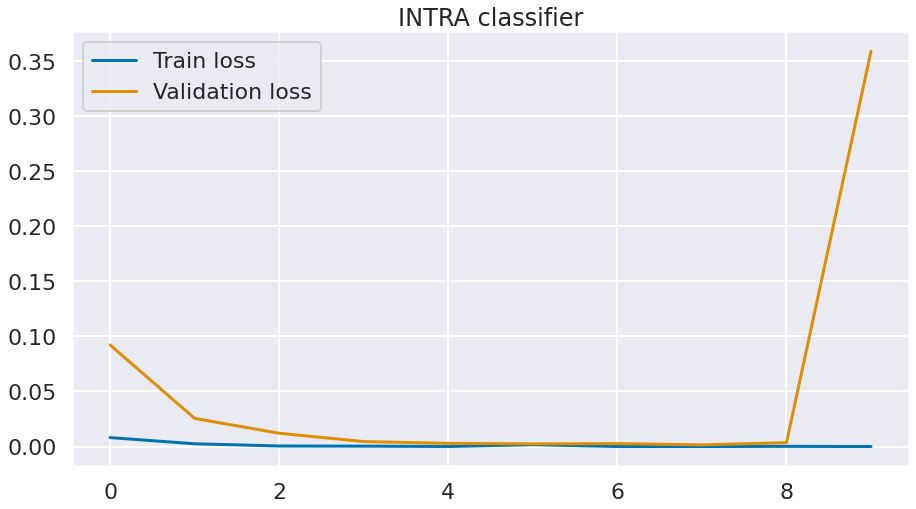

In [ ]:
plot_loss(history, val_history, "INTRA classifier")

In [ ]:
# Load the best model
model = MEGClassifier(3).to(device)
model.load_state_dict(torch.load("model_intra_7.pt"))

<All keys matched successfully>

In [ ]:
pred_labels, true_labels, accuracy, precision, recall, reports, confusion = test_metrics(model, intra_data_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print(reports)
print("Confusion matrix:\n", confusion)

Accuracy: 0.999785836664763
Precision: 0.9997857958251795
Recall: 0.9997859181692926
              precision    recall  f1-score   support

        rest       1.00      1.00      1.00      3498
        math       1.00      1.00      1.00      3504
      memory       1.00      1.00      1.00      3503
       motor       1.00      1.00      1.00      3503

    accuracy                           1.00     14008
   macro avg       1.00      1.00      1.00     14008
weighted avg       1.00      1.00      1.00     14008

Confusion matrix:
 [[3498    0    0    0]
 [   1 3503    0    0]
 [   1    1 3501    0]
 [   0    0    0 3503]]


### Cross case

In [ ]:
cross_classifier = MEGClassifier(3).to(device)

In [ ]:
# get_train = lambda: make_train_sets()[3]
history, val_history = train(cross_classifier, cross_data_train, cross_data_test1, epochs=10, lr=1e-5, name="cross")

EPOCH 1:
  batch 10 loss: 0.12807748317718506
  batch 20 loss: 0.11980638504028321
  batch 30 loss: 0.10599658489227295
  batch 40 loss: 0.09648852348327637
  batch 50 loss: 0.08954976201057434
  batch 60 loss: 0.07914366722106933
  batch 70 loss: 0.0752835214138031
  batch 80 loss: 0.07331516146659851
  batch 90 loss: 0.0702958881855011
  batch 100 loss: 0.06352424621582031
  batch 110 loss: 0.06572521328926087
  batch 120 loss: 0.0555763840675354
  batch 130 loss: 0.05724060535430908
  batch 140 loss: 0.06175472140312195
  batch 150 loss: 0.05558823347091675
  batch 160 loss: 0.05200185775756836
  batch 170 loss: 0.04113795161247254
  batch 180 loss: 0.04205756783485413
  batch 190 loss: 0.04151773750782013
  batch 200 loss: 0.04132893979549408
  batch 210 loss: 0.03932381570339203
  batch 220 loss: 0.03525987267494202
  batch 230 loss: 0.03238921165466309
  batch 240 loss: 0.031010884046554565
  batch 250 loss: 0.025905543565750123
  batch 260 loss: 0.02766331434249878
  batch 270 l

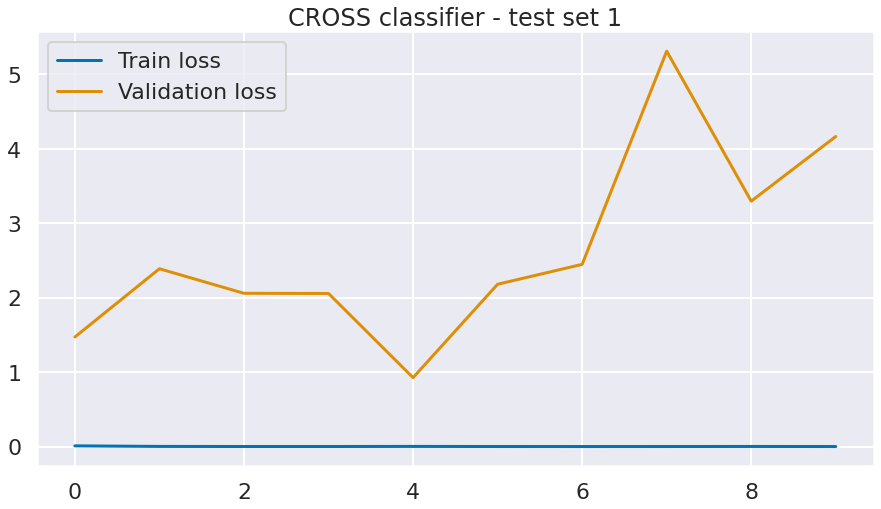

In [ ]:
plot_loss(history, val_history, "CROSS classifier - test set 1")

In [ ]:
# Load the best model
model = MEGClassifier(3).to(device)
model.load_state_dict(torch.load("model_cross_0.pt"))

<All keys matched successfully>

In [ ]:
print("############# Test Set 1 #############")
pred_labels1, true_labels1, accuracy1, precision1, recall1, reports1, confusion1 = test_metrics(model, cross_data_test1)
print("Accuracy:", accuracy1)
print("Precision:", precision1)
print("Recall:", recall1)
print(reports1)
print("Confusion matrix:\n", confusion1)

print("############# Test Set 2 #############")
pred_labels2, true_labels2, accuracy2, precision2, recall2, reports2, confusion2 = test_metrics(model, cross_data_test2)
print("Accuracy:", accuracy2)
print("Precision:", precision2)
print("Recall:", recall2)
print(reports2)
print("Confusion matrix:\n", confusion2)

print("############# Test Set 2 #############")
pred_labels3, true_labels3, accuracy3, precision3, recall3, reports3, confusion3 = test_metrics(model, cross_data_test3)
print("Accuracy:", accuracy3)
print("Precision:", precision3)
print("Recall:", recall3)
print(reports3)
print("Confusion matrix:\n", confusion3)

############# Test Set 1 #############
Accuracy: 0.47458595088520844
Precision: 0.5873462657444807
Recall: 0.47451891282029235
              precision    recall  f1-score   support

        rest       1.00      0.27      0.43      6997
        math       0.77      0.53      0.63      7007
      memory       0.18      0.10      0.13      7006
       motor       0.40      0.99      0.57      7006

    accuracy                           0.47     28016
   macro avg       0.59      0.47      0.44     28016
weighted avg       0.59      0.47      0.44     28016

Confusion matrix:
 [[1906    1    0 5090]
 [   7 3739 3261    0]
 [   1 1108  733 5164]
 [   0    1   87 6918]]
############# Test Set 2 #############
Accuracy: 0.4634494574528841
Precision: 0.37507179598025275
Recall: 0.46331960430438224
              precision    recall  f1-score   support

        rest       0.46      0.85      0.60      7006
        math       0.08      0.01      0.02      6998
      memory       0.00      0.00   

## Testing

In [ ]:
# Load the best model
cross_classifier = MEGClassifier(3).to(device)
cross_classifier.load_state_dict(torch.load("model_cross_0.pt"))
# Load the best model
intra_classifier = MEGClassifier(3).to(device)
intra_classifier.load_state_dict(torch.load("model_intra_7.pt"))

<All keys matched successfully>

In [ ]:
pred_labels, true_labels, accuracy, precision, recall, reports, confusion = test_metrics(cross_classifier, intra_data_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print(reports)
print("Confusion matrix:\n", confusion)

Accuracy: 0.9937178754997145
Precision: 0.9938675199798368
Recall: 0.9937206261234662
              precision    recall  f1-score   support

        rest       1.00      1.00      1.00      3498
        math       1.00      0.99      0.99      3504
      memory       0.98      1.00      0.99      3503
       motor       1.00      0.99      0.99      3503

    accuracy                           0.99     14008
   macro avg       0.99      0.99      0.99     14008
weighted avg       0.99      0.99      0.99     14008

Confusion matrix:
 [[3498    0    0    0]
 [   0 3457   47    0]
 [   0    1 3502    0]
 [   0    0   40 3463]]


In [ ]:
print("############# Test Set 1 #############")
pred_labels1, true_labels1, accuracy1, precision1, recall1, reports1, confusion1 = test_metrics(intra_classifier, cross_data_test1)
print("Accuracy:", accuracy1)
print("Precision:", precision1)
print("Recall:", recall1)
print(reports1)
print("Confusion matrix:\n", confusion1)

print("############# Test Set 2 #############")
pred_labels2, true_labels2, accuracy2, precision2, recall2, reports2, confusion2 = test_metrics(intra_classifier, cross_data_test2)
print("Accuracy:", accuracy2)
print("Precision:", precision2)
print("Recall:", recall2)
print(reports2)
print("Confusion matrix:\n", confusion2)

print("############# Test Set 3 #############")
pred_labels3, true_labels3, accuracy3, precision3, recall3, reports3, confusion3 = test_metrics(intra_classifier, cross_data_test3)
print("Accuracy:", accuracy3)
print("Precision:", precision3)
print("Recall:", recall3)
print(reports3)
print("Confusion matrix:\n", confusion3)

############# Test Set 1 #############
Accuracy: 0.3999143346659052
Precision: 0.41695500276041
Recall: 0.3997835950032526
              precision    recall  f1-score   support

        rest       0.25      0.00      0.00      6997
        math       0.80      0.47      0.59      7007
      memory       0.09      0.13      0.11      7006
       motor       0.53      1.00      0.69      7006

    accuracy                           0.40     28016
   macro avg       0.42      0.40      0.35     28016
weighted avg       0.42      0.40      0.35     28016

Confusion matrix:
 [[   1    0 6066  930]
 [   1 3264 3742    0]
 [   1  816  936 5253]
 [   1    2    0 7003]]
############# Test Set 2 #############
Accuracy: 0.7884066247858367
Precision: 0.7881226823312776
Recall: 0.788342038429152
              precision    recall  f1-score   support

        rest       1.00      1.00      1.00      7006
        math       0.58      0.56      0.57      6998
      memory       0.57      0.59      0.58

## Hyperparameter search

In [ ]:
def random_search(model, samples, param_range, epochs=4, is_cross=True):
    # param_range: dictionary with generators for the parameters
    best_model = None
    best_param = None
    best_accuracy = 0
    for i in range(samples):

        if is_cross:
            train_ = cross_data_train
            test_ = cross_data_test1
        else:
            train_ = intra_data_train
            test_ = intra_data_test

        sample_param = {}
        for k, v in param_range.items():
            sample_param[k] = v()
        classifier = MEGClassifier(**sample_param).to(device)
        history, val_history = train(classifier, train_, test_, epochs=epochs, lr=2e-5, name=f"random_search_{is_cross}_{i}")
        pred_labels, true_labels, accuracy, precision, recall, reports, confusion = test_metrics(classifier, test_)

        if accuracy > best_accuracy:
            best_model = classifier
            best_param = sample_param
            best_accuracy = accuracy
    return best_model, best_param, best_accuracy

In [ ]:
param_range = {
    "res_blocks": lambda: np.random.choice([1, 3, 5], 1).item(),
    "res_block_size": lambda: np.random.choice([2, 3], 1).item(), 
    "input_channels": lambda: 248, 
    "downsample": lambda: 0.5
}

In [ ]:
best_model, best_cross_param, best_cross_accuracy = random_search(MEGClassifier, 10, param_range, epochs=3, is_cross=True)
print(best_cross_param)
print("Accuracy:", best_cross_accuracy)
torch.save(best_model.state_dict(), "best_cross_model")

EPOCH 1:
  batch 10 loss: 0.13013877868652343
  batch 20 loss: 0.11290889978408813
  batch 30 loss: 0.09670919179916382
  batch 40 loss: 0.08013597130775452
  batch 50 loss: 0.06852532625198364
  batch 60 loss: 0.057302439212799074
  batch 70 loss: 0.050299590826034545
  batch 80 loss: 0.04734691083431244
  batch 90 loss: 0.045319277048110965
  batch 100 loss: 0.034149950742721556
  batch 110 loss: 0.032622674107551576
  batch 120 loss: 0.024947550892829896
  batch 130 loss: 0.02263665497303009
  batch 140 loss: 0.017024631798267364
  batch 150 loss: 0.01217714548110962
  batch 160 loss: 0.01379900872707367
  batch 170 loss: 0.01298072338104248
  batch 180 loss: 0.008580560982227325
  batch 190 loss: 0.006281262636184693
  batch 200 loss: 0.005419099330902099
  batch 210 loss: 0.007340378314256668
  batch 220 loss: 0.004097068309783935
  batch 230 loss: 0.004906826838850975
  batch 240 loss: 0.005060631036758423
  batch 250 loss: 0.004401919990777969
  batch 260 loss: 0.002272946387529

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

EPOCH 1:
  batch 10 loss: 0.1257521390914917
  batch 20 loss: 0.10909409523010254
  batch 30 loss: 0.0936348557472229
  batch 40 loss: 0.07828993201255799
  batch 50 loss: 0.06846886873245239
  batch 60 loss: 0.06605583429336548
  batch 70 loss: 0.0625554621219635
  batch 80 loss: 0.0629896104335785
  batch 90 loss: 0.0493851900100708
  batch 100 loss: 0.042828336358070374
  batch 110 loss: 0.04213797450065613
  batch 120 loss: 0.032576605677604675
  batch 130 loss: 0.02596684992313385
  batch 140 loss: 0.020522518455982207
  batch 150 loss: 0.01935880780220032
  batch 160 loss: 0.016745400428771973
  batch 170 loss: 0.010215936601161957
  batch 180 loss: 0.011330153048038482
  batch 190 loss: 0.00999646782875061
  batch 200 loss: 0.006212945282459259
  batch 210 loss: 0.006443243473768234
  batch 220 loss: 0.0058249164372682575
  batch 230 loss: 0.005382799357175827
  batch 240 loss: 0.004973930865526199
  batch 250 loss: 0.0033547937870025634
  batch 260 loss: 0.003273835778236389
  

In [ ]:
best_model, best_intra_param, best_intra_accuracy = random_search(MEGClassifier, 10, param_range, epochs=3, is_cross=False)
print(best_intra_param) 
print("Accuracy:", best_intra_accuracy)
torch.save(best_model.state_dict(), "best_intra_model")

EPOCH 1:
  batch 10 loss: 0.13197420835494994
  batch 20 loss: 0.12483580112457275
  batch 30 loss: 0.12011351585388183
  batch 40 loss: 0.11039061546325683
  batch 50 loss: 0.1130754828453064
  batch 60 loss: 0.09175769686698913
  batch 70 loss: 0.08726482391357422
  batch 80 loss: 0.08857428431510925
  batch 90 loss: 0.07515971660614014
  batch 100 loss: 0.08180712461471558
  batch 110 loss: 0.07444244623184204
  batch 120 loss: 0.06643311977386475
  batch 130 loss: 0.06046581268310547
  batch 140 loss: 0.05970296859741211
  batch 150 loss: 0.049365836381912234
  batch 160 loss: 0.05088521838188172
  batch 170 loss: 0.04351428747177124
  batch 180 loss: 0.04345833659172058
  batch 190 loss: 0.05097985863685608
  batch 200 loss: 0.040048837661743164
  batch 210 loss: 0.040775781869888304
  batch 220 loss: 0.03758789896965027
  batch 230 loss: 0.03778159022331238
  batch 240 loss: 0.03658191561698913
  batch 250 loss: 0.026833939552307128
  batch 260 loss: 0.026677852869033812
  batch 